# Auswertungshilfe

Im Folgenden finden Sie Rezepte und kurze Anleitungen, die Ihnen bei der Auswertung der Daten helfen sollen. Sie können jedes beliebige Tool für die Auswertung verwenden, solange Sie zu einem brauchbaren Ergebnis kommen. Stark empfohlen wird die Verwendung von Python-Skripten.


## 1. Einlesen und Korrektur

Korrektur der Aufnahmen mittels der gewonnenen Bias-, Dark- und Flat-Aufnahmen (siehe bereitgestelltes PDF in Moodle). Hierfür können Python-Funktionen verwendet werden. Beispiele von einfachen Operationen, siehe auch die [Astropy Dokumentation](https://docs.astropy.org/en/stable/io/fits/).

Bias, Dark und Flat Korrektur werden an die Science Frames wie folgt angewandt:

$$
\mathrm{science frame} = \frac{\mathrm{raw science frame}- \mathrm{master dark} - \mathrm{master bias}}{\mathrm{master flat} /  \langle\mathrm{master flat}\rangle }
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from astropy.table import Table
from astropy.modeling import models, fitting
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.integrate import simpson
import os
import pandas as pd

ROOT = os.path.dirname(os.path.realpath("__file__"))
PATH = '/Gruppe8/'

In [2]:
#Fetch Data-Files
files = [file for file in os.listdir(ROOT+PATH) if file.endswith('fit')]

#Split Filenames for Sorting and def Sorting-Frame
tempArr = []
for file in files:
    nr = file.split('_')[0]
    if file.endswith('fit') == True:
        tempArr.append(int(nr))
    else:
        tempArr.append(None)

#Lookup DF Nr-File
fileFrame = pd.DataFrame({'Nr': tempArr, 'Files': files})
fileFrame.sort_values(['Nr', 'Files'], inplace=True)

#Fetch Data
def openFit(fileName):
    with fits.open(ROOT+PATH+fileName) as fit:
        data = fit[0].data
    return data

#Extract Header and Data from Files and prep plotable axis
Flats = pd.DataFrame(columns=['Nr', 'Flat'])
Darks = pd.DataFrame(columns=['Nr', 'Dark'])
Biases = pd.DataFrame(columns=['Nr', 'Bias'])
SunThAr = pd.DataFrame(columns=['Nr', 'Spectra'])
Filters = pd.DataFrame(columns=['Nr', 'Filter'])

#Sort Dark, Bias and Flat Files
for idx, row in fileFrame.iterrows():
    nr = row['Nr']
    fileName = row['Files']
    fitData = openFit(fileName)

    if fileName.find('bias') != -1:
        Biases.loc[len(Biases)] = [nr, fitData]

    elif fileName.find('dark') != -1:
        Darks.loc[len(Darks)] = [nr, fitData]

    elif fileName.find('flat') != -1:
        Flats.loc[len(Flats)] = [nr, fitData]

    elif fileName.find('Sun_ThAr') != -1:
        SunThAr.loc[len(SunThAr)] = [nr, fitData]

    else:
        Filters.loc[len(Filters)] = [nr, fitData]

In [3]:
# Ich hätte die Filterkurven gerne als normalen raw frame und weiss nicht wie ich das oben einbaue
with fits.open('Gruppe8/1_filter_F.fit') as file:
    Filter_F = file[0].data

with fits.open('Gruppe8/1_filter_I.fit') as file:
    Filter_I = file[0].data

## 2. Stacken, Extrahieren 1D Spektrum

Erstellung von gemittelten Aufnahmen zur Verbesserung des Signals und zum Zweck der Verwerfung von Ausreißern (z.B. Cosmics).

In [4]:
#Image Stacking
biasFrame = np.median(np.array(Biases['Bias'].tolist()), axis=0)
darkFrame = np.median(np.array(Darks['Dark'].tolist()), axis=0)
flatFrame = np.median(np.array(Flats['Flat'].tolist()), axis=0)
sunThArFrame = np.median(np.array(SunThAr['Spectra'].tolist()), axis=0)

flatFrame_normalized = flatFrame / np.mean(flatFrame)

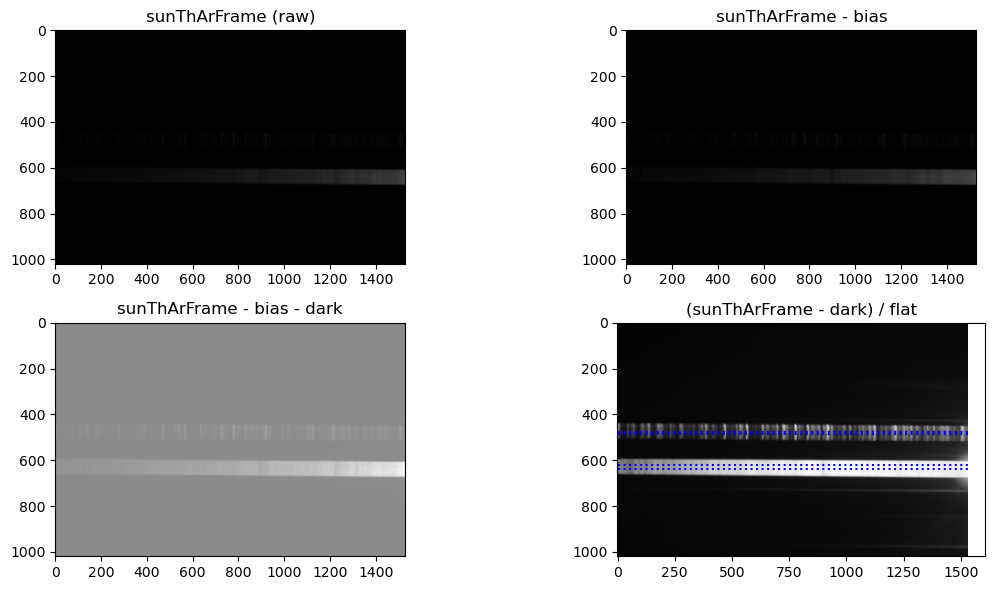

In [5]:
# Plot of different Frames
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].imshow(sunThArFrame, cmap='grey')
ax[0, 0].set_title('sunThArFrame (raw)')

ax[0, 1].imshow(sunThArFrame-biasFrame, cmap='grey')
ax[0, 1].set_title('sunThArFrame - bias')

ax[1, 0].imshow(sunThArFrame-darkFrame-biasFrame, cmap='grey')
ax[1, 0].set_title('sunThArFrame - bias - dark')

ax[1, 1].imshow((sunThArFrame-biasFrame-darkFrame) / flatFrame_normalized, cmap='grey')
ax[1, 1].set_title('(sunThArFrame - dark) / flat')
ax[1, 1].hlines(y=620, xmin=0, xmax=1530, color='blue', linestyle='dotted')
ax[1, 1].hlines(y=640, xmin=0, xmax=1530, color='blue', linestyle='dotted')
ax[1, 1].hlines(y=475, xmin=0, xmax=1530, color='blue', linestyle='dotted')
ax[1, 1].hlines(y=485, xmin=0, xmax=1530, color='blue', linestyle='dotted')

plt.tight_layout()
plt.show()

In [6]:
# Define sciene frame for ThAr-lines
ThArFrame_science = (sunThArFrame - biasFrame - darkFrame) / flatFrame_normalized

# Define sciene frame for ThAr-lines
sunFrame_science = (sunThArFrame - biasFrame - darkFrame) / flatFrame_normalized

# Define science frame for filter F
Filter_F_frame = (Filter_F - biasFrame - darkFrame)

# Define science frame for filter I
Filter_I_frame = (Filter_I - biasFrame - darkFrame)

Extraktion eines 1-dimensionalen Spektrums: Von den kalibrierten Aufnahmen kann ein 1-dimensionales Spektrum extrahiert werden, indem ein Rechteck an der passenden Stelle ausgeschnitten wird. Darauf folgend berechnet man den Median entlang einer Pixelsäule.

In [7]:
#Cutout filter
#cutoutFilter_F = Filters['Filter'][0][920:1220, 350:410]
#Spectfilter_F = np.nanmedian(cutoutFilter_F, axis=0)
#cutoutFilter_I = Filters['Filter'][1][780:990, 350:410]
#Spectfilter_I = np.nanmedian(cutoutFilter_I, axis=0)

#Define filter F and I spectra
cutoutFilter_F = Filter_F_frame[620:640, :]
Spectfilter_F = np.nanmedian(cutoutFilter_F, axis=0)
cutoutFilter_I = Filter_I_frame[620:640, :]
Spectfilter_I = np.nanmedian(cutoutFilter_I, axis=0)

# Define ThAr spectrum
cutoutThArSpect = ThArFrame_science[475:485, :]
ThArSpect = np.nanmedian(cutoutThArSpect, axis=0)

# Define Sun spectrum 
cutoutSunSpect = sunFrame_science[620:640, :]
sunSpect = np.nanmedian(cutoutSunSpect, axis=0)

# Define Sun spectrum without flat
sunFrame_without_flat = (sunThArFrame - biasFrame - darkFrame)
cutoutSunSpect_without_flat = sunFrame_without_flat[620:640, :]
sunSpect_without_flat = np.nanmedian(cutoutSunSpect_without_flat, axis=0)

In [8]:
# Compare ThAr-Spectrum to Linienatlas
ThArSpect_shifted = ThArSpect - min(ThArSpect)
ThArSpect_normalized = ThArSpect_shifted / max(ThArSpect_shifted)

# Define threshold for peaks
ThAr_peaks_threshold = 0.53

# Calculate peaks
ThAr_peaks, ThAr_peaks_properties = find_peaks(ThArSpect_normalized, height=ThAr_peaks_threshold, distance=70, prominence=0.45)

# Identify wavelength for peaks based on Linienatlas

ThAr_peaks_wavelength = np.zeros(len(ThAr_peaks))

ThAr_peaks_wavelength[0] = 4348.06
ThAr_peaks_wavelength[1] = 4493.33 # Bezugspunkt
ThAr_peaks_wavelength[2] = 4545.05
ThAr_peaks_wavelength[3] = 4609.57
ThAr_peaks_wavelength[4] = 4657.09
ThAr_peaks_wavelength[5] = 4764.86
ThAr_peaks_wavelength[6] = 4879.86
ThAr_peaks_wavelength[7] = 5067.97
ThAr_peaks_wavelength[8] = 5158.60
ThAr_peaks_wavelength[9] = 5231.16

# Fit positions of pixels and wavelength using polynomial 2nd degree
coeff_2 = np.polynomial.Polynomial.fit(ThAr_peaks, ThAr_peaks_wavelength, 2)
coeff_3 = np.polynomial.Polynomial.fit(ThAr_peaks, ThAr_peaks_wavelength, 3)

# Calculate curve for conversion pixel position to wavelength
x_fit = np.arange(0, 1530, 1)
y_fit_2 = coeff_2(x_fit)
y_fit_3 = coeff_3(x_fit)

## 3. Kombinierte Flat Korrektur

Idee: Das Flat das durch den Spektrographen aufgenommen wird enthält das Black-Body Spektrum der Tischlampe. Um dieses auszukorrigieren, nehmen wir ein zusätzliches Flat auf, das bereits korrigiert ist (Silva-Nova Spektrometer), durch welches das Spektrograph Flat dividiert werden soll. 

Dafür ist zu beachten dass das Wellenlängen-sampling der beiden Flats anders ist. Kontrollieren Sie nach in welchen Wellenlängbereichen die beiden Flats aufgenommen wurden. 

Tip: Mit Interpolieren (zB `interp1d`) kann man das erwünschte sampling für das Nova Spektrometer erhalten.

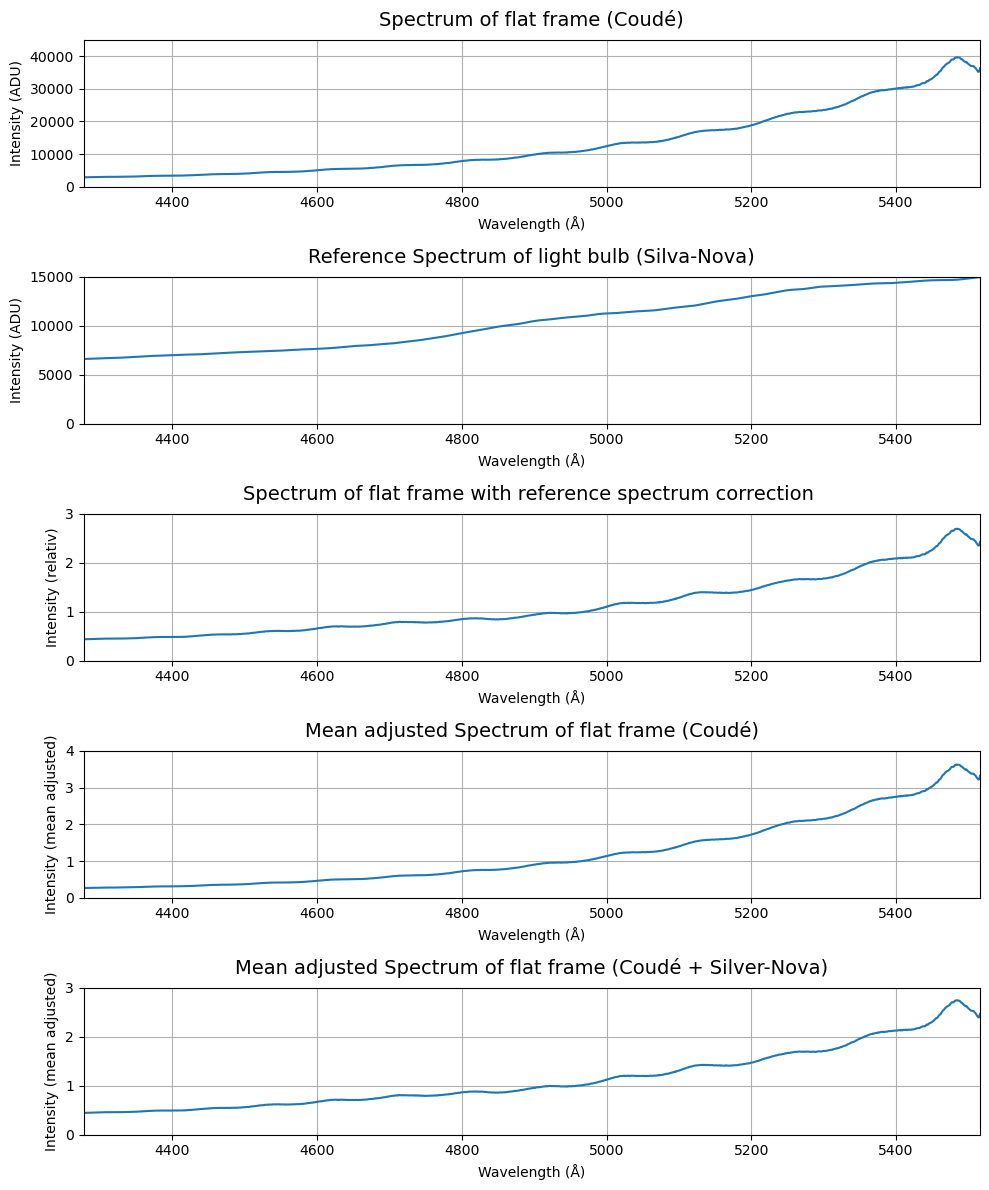

In [9]:
# Define Flat spectrum within slice of Sun´s spectrum 
cutoutFlatSpect = flatFrame[620:640, :]
flatSpect = np.nanmedian(cutoutFlatSpect, axis=0)
flatSpect_normalized = flatSpect / np.mean(flatSpect)

# Fetch reference spectrum of light bulb (Silva-Nova Spectrometer) and convert nm to Ångström
refFlat = pd.read_csv(ROOT+PATH+"silvernova.SSM", sep='\\s+', names=['wavelength', 'flux'], skiprows=1)
refFlat['wavelength'] = refFlat['wavelength'] * 10

# Adjust to proper wavelength boundaries
refFlat = refFlat.loc[(min(y_fit_3) <= refFlat['wavelength']) & (refFlat['wavelength'] <= max(y_fit_3)), ['wavelength', 'flux']]

# Split array in wavelength and flux
wavelength_refFlat = refFlat['wavelength'].to_numpy()
flux_refFlat = refFlat['flux'].to_numpy()

# Interpolation of light buld spectrum (Silva-Nova Spectrometer)
refFlat_interpolated = interp1d(wavelength_refFlat, flux_refFlat, kind='linear', fill_value='extrapolate')
flux_refFlat_interpolated = refFlat_interpolated(y_fit_3)

# Calculate correction of light bulb flat frame
flatSpect_corrected = flatSpect / flux_refFlat_interpolated
flatSpect_corrected_normalized = flatSpect_corrected / np.mean(flatSpect_corrected)

fig, ax = plt.subplots(5, 1, figsize=(10, 12))
ax[0].plot(y_fit_3, flatSpect)
ax[0].set_xlim(min(y_fit_3), max(y_fit_3))
ax[0].set_ylim(0, 45000)
ax[0].set_xlabel(r'Wavelength (Å)')
ax[0].set_ylabel('Intensity (ADU)')
ax[0].set_title('Spectrum of flat frame (Coudé)', fontsize=14, pad=10)
ax[0].grid()

ax[1].plot(y_fit_3, flux_refFlat_interpolated)
ax[1].set_xlim(min(y_fit_3), max(y_fit_3))
ax[1].set_ylim(0, 15000)
ax[1].set_xlabel(r'Wavelength (Å)')
ax[1].set_ylabel('Intensity (ADU)')
ax[1].set_title('Reference Spectrum of light bulb (Silva-Nova)', fontsize=14, pad=10)
ax[1].grid()

ax[2].plot(y_fit_3, flatSpect_corrected)
ax[2].set_xlim(min(y_fit_3), max(y_fit_3))
ax[2].set_ylim(0, 3)
ax[2].set_xlabel(r'Wavelength (Å)')
ax[2].set_ylabel('Intensity (relativ)')
ax[2].set_title('Spectrum of flat frame with reference spectrum correction ', fontsize=14, pad=10)
ax[2].grid()

ax[3].plot(y_fit_3, flatSpect_normalized)
ax[3].set_xlim(min(y_fit_3), max(y_fit_3))
ax[3].set_ylim(0, 4)
ax[3].set_xlabel(r'Wavelength (Å)')
ax[3].set_ylabel('Intensity (mean adjusted)')
ax[3].set_title('Mean adjusted Spectrum of flat frame (Coudé)', fontsize=14, pad=10)
ax[3].grid()

ax[4].plot(y_fit_3, flatSpect_corrected_normalized)
ax[4].set_xlim(min(y_fit_3), max(y_fit_3))
ax[4].set_ylim(0, 3)
ax[4].set_xlabel(r'Wavelength (Å)')
ax[4].set_ylabel('Intensity (mean adjusted)')
ax[4].set_title('Mean adjusted Spectrum of flat frame (Coudé + Silver-Nova)', fontsize=14, pad=10)
ax[4].grid()

plt.tight_layout()
plt.show()

## 4. Wellenlängekalibration
Identifikation der ThAr-Linien. Zur Identifikation der Linien soll der beigelegte Linienatlas verwendet werden. Beachten Sie, dass das aufgenommene Spektrum Wellenlängen von 4200 bis 5500 abdeckt.

Für das finden der peaks kann zB von `scipy.signal` die funktion `find_peaks`verwendet werden.


Erstellung einer Wellenlängenkalibration auf Basis der identifizierten Linien. Hierfür erstellen Sie einen Fit zwischen Pixelkoordinaten und Wellenlänge der identifizierten Linien. Sie können hierfür numpy verwenden

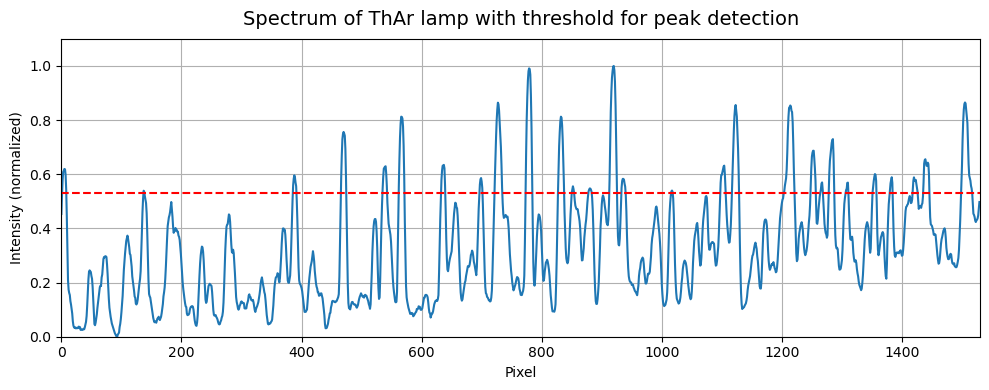

In [10]:
# Plot ThAr-lines related to Linienatlas
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(ThArSpect_normalized)
ax.set_xlim(0, 1530)
ax.set_ylim(0, 1.1)
ax.hlines(y=ThAr_peaks_threshold, xmin=0, xmax=1530, color='red', linestyle='dashed')
ax.set_xlabel('Pixel')
ax.set_ylabel('Intensity (normalized)')
ax.set_title('Spectrum of ThAr lamp with threshold for peak detection', fontsize=14, pad=10)
ax.grid()

plt.tight_layout()
plt.show()

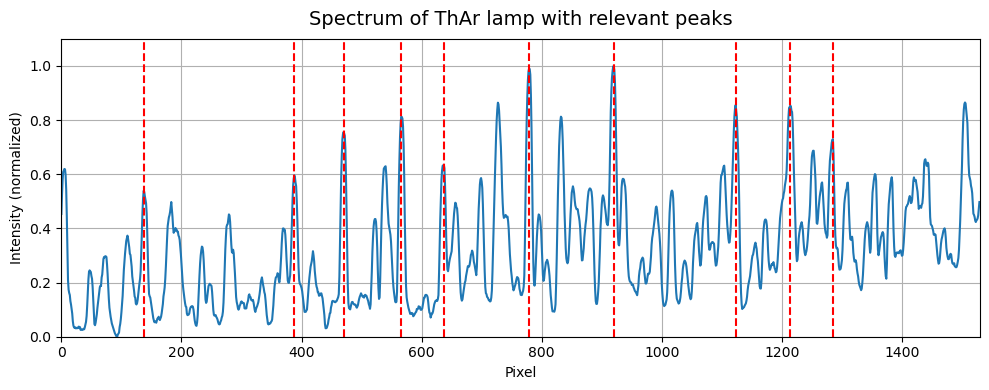

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(ThArSpect_normalized)
#ax.plot(ThAr_peaks, ThArSpect_normalized[ThAr_peaks], "x", color='r')
ax.set_xlim(0, 1530)
ax.set_ylim(0, 1.1)
ax.vlines(x=ThAr_peaks[0], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks[1], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks[2], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks[3], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks[4], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks[5], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks[6], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks[7], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks[8], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks[9], ymin=0, ymax=1.1, color='red', linestyle='--')
#ax.hlines(y=ThAr_peaks_threshold, xmin=0, xmax=1530, color='red', linestyle='dashed')
ax.set_xlabel('Pixel')
ax.set_ylabel('Intensity (normalized)')
ax.set_title('Spectrum of ThAr lamp with relevant peaks', fontsize=14, pad=10)
ax.grid()

plt.tight_layout()
plt.show()


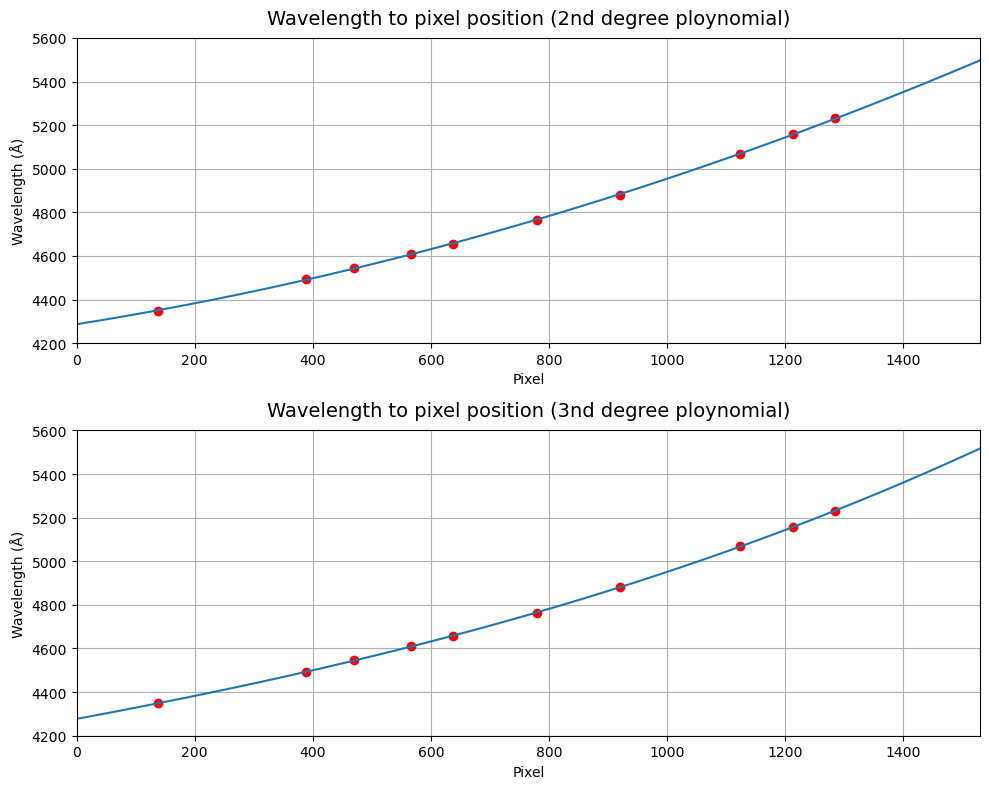

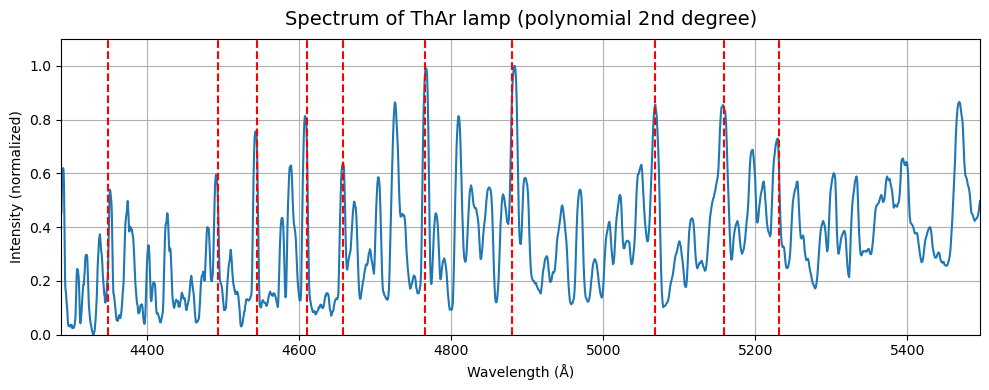

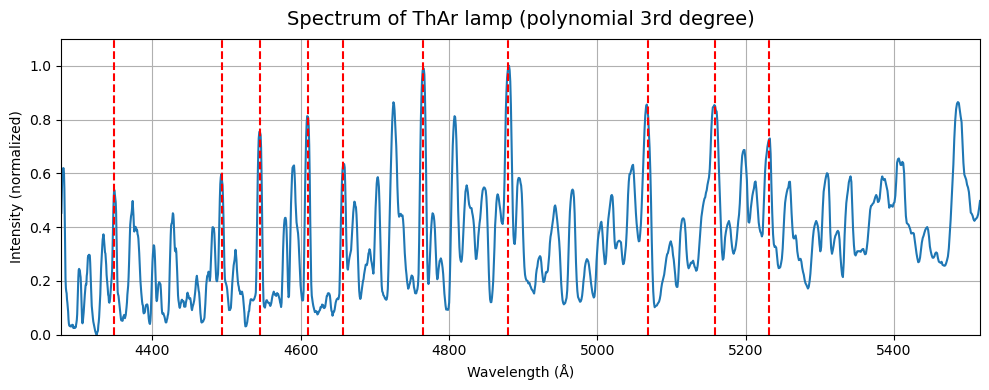

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(ThAr_peaks, ThAr_peaks_wavelength, "o", color='r')
ax[0].plot(x_fit, y_fit_2)
ax[0].set_xlim(0, 1530)
ax[0].set_ylim(4200, 5600)
ax[0].set_xlabel('Pixel')
ax[0].set_ylabel(r'Wavelength (Å)')
ax[0].set_title('Wavelength to pixel position (2nd degree ploynomial)', fontsize=14, pad=10)
ax[0].grid()

ax[1].plot(ThAr_peaks, ThAr_peaks_wavelength, "o", color='r')
ax[1].plot(x_fit, y_fit_3)
ax[1].set_xlim(0, 1530)
ax[1].set_ylim(4200, 5600)
ax[1].set_xlabel('Pixel')
ax[1].set_ylabel(r'Wavelength (Å)')
ax[1].set_title('Wavelength to pixel position (3nd degree ploynomial)', fontsize=14, pad=10)
ax[1].grid()

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(y_fit_2, ThArSpect_normalized)
ax.set_xlim(min(y_fit_2), max(y_fit_2))
ax.set_ylim(0, 1.1)
ax.vlines(x=ThAr_peaks_wavelength[0], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[1], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[2], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[3], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[4], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[5], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[6], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[7], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[8], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[9], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.set_xlabel(r'Wavelength (Å)')
ax.set_ylabel('Intensity (normalized)')
ax.set_title('Spectrum of ThAr lamp (polynomial 2nd degree)', fontsize=14, pad=10)
ax.grid()

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(y_fit_3, ThArSpect_normalized)
ax.set_xlim(min(y_fit_3), max(y_fit_3))
ax.set_ylim(0, 1.1)
ax.vlines(x=ThAr_peaks_wavelength[0], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[1], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[2], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[3], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[4], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[5], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[6], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[7], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[8], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.vlines(x=ThAr_peaks_wavelength[9], ymin=0, ymax=1.1, color='red', linestyle='--')
ax.set_xlabel(r'Wavelength (Å)')
ax.set_ylabel('Intensity (normalized)')
ax.set_title('Spectrum of ThAr lamp (polynomial 3rd degree)', fontsize=14, pad=10)
ax.grid()

plt.tight_layout()
plt.show()

Die so erstellte Interpolation kann nun verwendet werden, um die Wellenlängenkalibration auf das Sonnenspektrum anzuwenden.

## 5. Spektrale Auflösung

Bestimmung der spektralen Auflösung aus der Breite der ThAr-Linien. Die Auflösung eines Spektrographen ist definiert durch
$$
        R \equiv \frac{\lambda}{\Delta \lambda},
$$
wobei hier R die Auflösung des Spektrographen darstellt, $\lambda$ die beobachtete Wellenlänge und $\Delta \lambda$ den kleinsten Unterschied in der Wellenlänge, den der Spektrograph auflösen kann. In der Praxis kann man für $\Delta \lambda$ die Full Width Half Maximum (FWHM) einer Linie bestimmen.

In [13]:
# Define arrays for Gaussian fit of 3 relevant peaks in ThAr spectrum (4348, 4764, 5068)
wavelength_ThAr_peak1 = np.array([])
wavelength_ThAr_peak2 = np.array([])
wavelength_ThAr_peak3 = np.array([])

spectrum_ThAr_peak1 = np.array([])
spectrum_ThAr_peak2 = np.array([])
spectrum_ThAr_peak3 = np.array([])


#Cutting out the data with wavelenght as parameter and not pixels
def cutoutRect(minWavelength, maxWavelength):
    filter = np.where(np.logical_and(y_fit_3 >= minWavelength, y_fit_3 <= maxWavelength))
    wavelenAx = y_fit_3[filter]
    peakAx = ThArSpect_normalized[filter]
    return wavelenAx, peakAx

wavelength_ThAr_peak1, spectrum_ThAr_peak1 = cutoutRect(4345, 4354)
wavelength_ThAr_peak2, spectrum_ThAr_peak2 = cutoutRect(4757, 4772.5)
wavelength_ThAr_peak3, spectrum_ThAr_peak3 = cutoutRect(5055.5, 5079)


R = lambda l, dl: l/dl

#FWHM with 50%/Y
def FWHM(X, Y):
    half_max = max(Y) / 2
    d = np.sign(half_max - np.array(Y[:-1])) - np.sign(half_max - np.array(Y[1:]))
    left_idx = np.where(d > 0)[0][0]
    right_idx = np.where(d < 0)[0][-1]
    return X[right_idx] - X[left_idx]


FWHM1 = FWHM(wavelength_ThAr_peak1, spectrum_ThAr_peak1)
FWHM2 = FWHM(wavelength_ThAr_peak2, spectrum_ThAr_peak2)
FWHM3 = FWHM(wavelength_ThAr_peak3, spectrum_ThAr_peak3)

R1 = R(ThAr_peaks_wavelength[0], FWHM1)
R2 = R(ThAr_peaks_wavelength[5], FWHM2)
R3 = R(ThAr_peaks_wavelength[6], FWHM3)

# Fit Gaussian to peaks
fit_gaussian = fitting.TRFLSQFitter()

gaussian_function_peak1 = models.Gaussian1D(amplitude=1, mean=4350, stddev=3)
gaussian_ThAr_peak1 = fit_gaussian(gaussian_function_peak1, wavelength_ThAr_peak1, spectrum_ThAr_peak1)
spectral_resolution_peak1 = gaussian_ThAr_peak1.mean / gaussian_ThAr_peak1.fwhm

gaussian_function_peak2 = models.Gaussian1D(amplitude=1, mean=4764, stddev=3)
gaussian_ThAr_peak2 = fit_gaussian(gaussian_function_peak2, wavelength_ThAr_peak2, spectrum_ThAr_peak2)
spectral_resolution_peak2 = gaussian_ThAr_peak2.mean / gaussian_ThAr_peak2.fwhm

gaussian_function_peak3 = models.Gaussian1D(amplitude=1, mean=5068, stddev=3)
gaussian_ThAr_peak3 = fit_gaussian(gaussian_function_peak3, wavelength_ThAr_peak3, spectrum_ThAr_peak3)
spectral_resolution_peak3 = gaussian_ThAr_peak3.mean / gaussian_ThAr_peak3.fwhm

print('with gaussian fit: \n')
print(f'peak1 mean: {gaussian_ThAr_peak1.mean.value} \n peak1 FWHM: {gaussian_ThAr_peak1.fwhm} \n peak1 R: {spectral_resolution_peak1} \n\n')
print(f'peak2 mean: {gaussian_ThAr_peak2.mean.value} \n peak2 FWHM: {gaussian_ThAr_peak2.fwhm} \n peak2 R: {spectral_resolution_peak2} \n\n')
print(f'peak3 mean: {gaussian_ThAr_peak3.mean.value} \n peak3 FWHM: {gaussian_ThAr_peak3.fwhm} \n peak3 R: {spectral_resolution_peak3} \n\n')

print('With 50%: \n')
print(f'peak1 mean: {ThAr_peaks_wavelength[0]} \n peak1 FWHM: {FWHM1} \n peak1 R: {R1} \n\n')
print(f'peak2 mean: {ThAr_peaks_wavelength[5]} \n peak2 FWHM: {FWHM2} \n peak2 R: {R2} \n\n')
print(f'peak3 mean: {ThAr_peaks_wavelength[7]} \n peak3 FWHM: {FWHM3} \n peak3 R: {R3} \n\n')


with gaussian fit: 

peak1 mean: 4349.10765896477 
 peak1 FWHM: 6.481260983009471 
 peak1 R: 671.0280098835536 


peak2 mean: 4764.991766294969 
 peak2 FWHM: 8.856619200114178 
 peak2 R: 538.0147501694032 


peak3 mean: 5065.782934227466 
 peak3 FWHM: 14.063429232843285 
 peak3 R: 360.20965088635694 


With 50%: 

peak1 mean: 4348.06 
 peak1 FWHM: 6.444945761298186 
 peak1 R: 674.6464843986807 


peak2 mean: 4764.86 
 peak2 FWHM: 9.407979523988615 
 peak2 R: 506.4700648901801 


peak3 mean: 5067.97 
 peak3 FWHM: 13.628456319403995 
 peak3 R: 358.0640305573073 




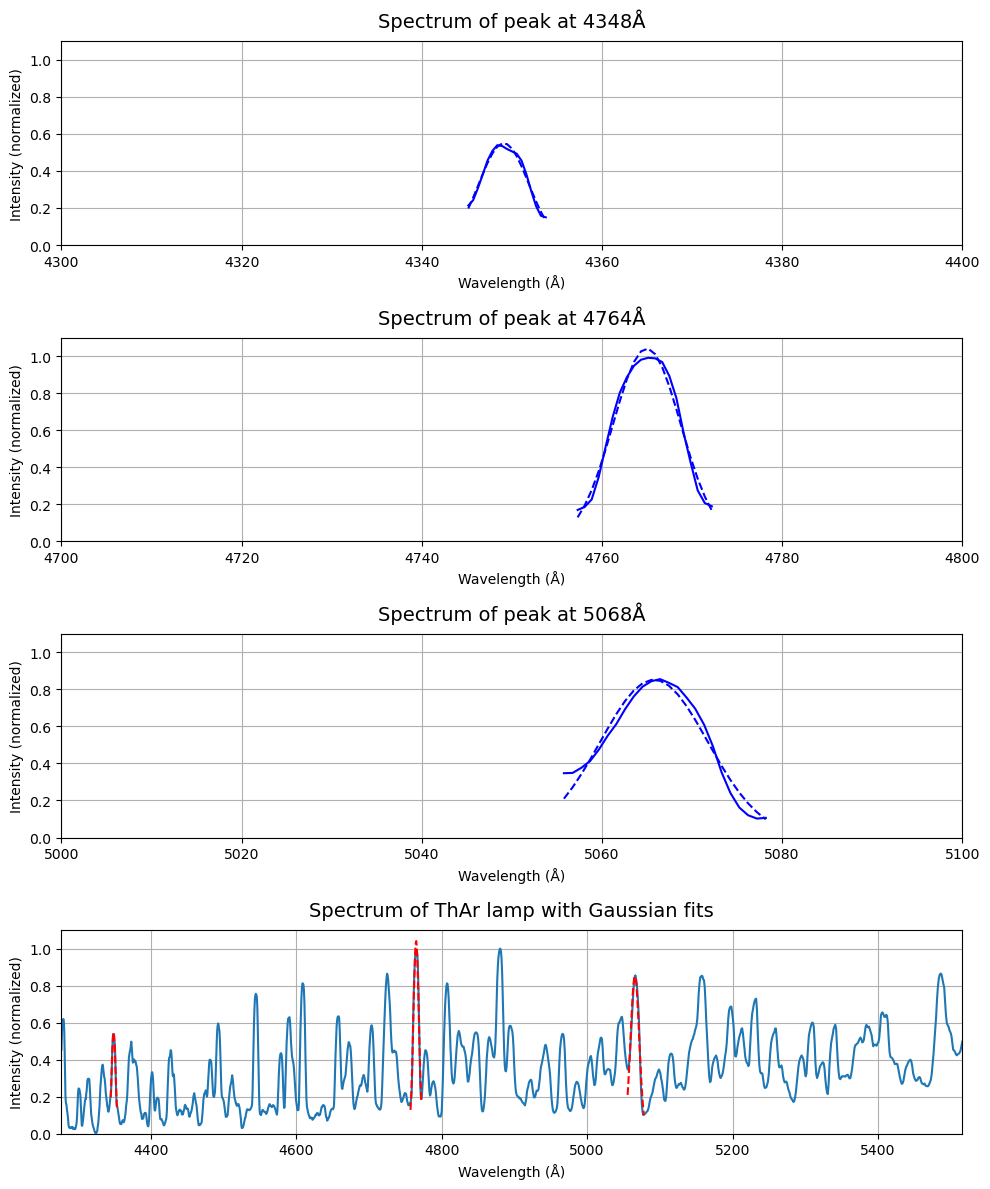

In [14]:
# relevant peaks and Gaussian fits
fig, ax = plt.subplots(4, 1, figsize=(10, 12))
ax[0].plot(wavelength_ThAr_peak1, spectrum_ThAr_peak1, color='blue')
ax[0].plot(wavelength_ThAr_peak1, gaussian_ThAr_peak1(wavelength_ThAr_peak1), color='blue', linestyle='dashed')
#ax[0].set_xlim(min(wavelength_ThAr_peak1), max(wavelength_ThAr_peak1))
ax[0].set_xlim(4300, 4400)
ax[0].set_ylim(0, 1.1)
ax[0].set_xlabel(r'Wavelength (Å)')
ax[0].set_ylabel('Intensity (normalized)')
ax[0].set_title('Spectrum of peak at 4348Å', fontsize=14, pad=10)
ax[0].grid()

ax[1].plot(wavelength_ThAr_peak2, spectrum_ThAr_peak2, color='blue')
ax[1].plot(wavelength_ThAr_peak2, gaussian_ThAr_peak2(wavelength_ThAr_peak2), color='blue', linestyle='dashed')
#ax[1].set_xlim(min(wavelength_ThAr_peak2), max(wavelength_ThAr_peak2))
ax[1].set_xlim(4700, 4800)
ax[1].set_ylim(0, 1.1)
ax[1].set_xlabel(r'Wavelength (Å)')
ax[1].set_ylabel('Intensity (normalized)')
ax[1].set_title('Spectrum of peak at 4764Å', fontsize=14, pad=10)
ax[1].grid()

ax[2].plot(wavelength_ThAr_peak3, spectrum_ThAr_peak3, color='blue')
ax[2].plot(wavelength_ThAr_peak3, gaussian_ThAr_peak3(wavelength_ThAr_peak3), color='blue', linestyle='dashed')
#ax[2].set_xlim(min(wavelength_ThAr_peak3), max(wavelength_ThAr_peak3))
ax[2].set_xlim(5000, 5100)
ax[2].set_ylim(0, 1.1)
ax[2].set_xlabel(r'Wavelength (Å)')
ax[2].set_ylabel('Intensity (normalized)')
ax[2].set_title('Spectrum of peak at 5068Å', fontsize=14, pad=10)
ax[2].grid()

ax[3].plot(y_fit_3, ThArSpect_normalized)
ax[3].plot(wavelength_ThAr_peak1, gaussian_ThAr_peak1(wavelength_ThAr_peak1), color='red', linestyle='dashed')
ax[3].plot(wavelength_ThAr_peak2, gaussian_ThAr_peak2(wavelength_ThAr_peak2), color='red', linestyle='dashed')
ax[3].plot(wavelength_ThAr_peak3, gaussian_ThAr_peak3(wavelength_ThAr_peak3), color='red', linestyle='dashed')
ax[3].set_xlim(min(y_fit_3), max(y_fit_3))
ax[3].set_ylim(0, 1.1)
ax[3].set_xlabel(r'Wavelength (Å)')
ax[3].set_ylabel('Intensity (normalized)')
ax[3].set_title('Spectrum of ThAr lamp with Gaussian fits', fontsize=14, pad=10)
ax[3].grid()

plt.tight_layout()
plt.show()

## 6. Signal-to-Noise Ratio

Abschätzung des Signal-Rausch-Verhältnisses (S/N) des Sonnenspektrums. Das S/N bei Spektren ist wegen unterschiedlicher Linienstärke wellenlängenabhängig. Die Angabe eines einzelnen S/N-Wertes für ein gesamtes Spektrum ist daher meistens nicht aussagekräftig. Zur Vereinfachung nehmen Sie an, dass die dominierende Rauschkomponente das Signal selbst ist, d.h. das Rauschen folgt einer Poissonverteilung nur abhängig vom Signal (den Gain der Kamera finden Sie im FITS-Header).

In [15]:
with fits.open(ROOT+PATH+'1_Sun_ThAr.fit') as fit:
        header = fit[0].header
        
# Define Sun spectra without flat frame
sunSpect_without_flat_normalized = sunSpect_without_flat  / max(sunSpect_without_flat)
sunSpect_normalized = sunSpect / max(sunSpect)

# Define Sun spectrum with corrected flat frame (already sliced)
sunSpect_corrected = sunSpect_without_flat / flatSpect_corrected_normalized
sunSpect_corrected_normalized = sunSpect_corrected / max(sunSpect_corrected)


def signaltonoise_dB(signal, axis=0, ddof=0):
    a = signal * header['EGAIN']
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return 20*np.log10(np.abs(np.where(sd == 0, 0, m/sd)))


print(signaltonoise_dB(sunSpect_without_flat_normalized))

-1.3512611039542128


In [31]:
gain = header['EGAIN']
sunSpect_shifted = sunSpect_corrected - min(sunSpect_corrected) # change all ThArSpect_shifted to this for SUN
sun_lines = np.array([4305, 4327, 4340, 4384, 4457, 4667, 4861, 5167, 5268])
coeff_inv = np.polynomial.Polynomial.fit(ThAr_peaks_wavelength, ThAr_peaks, 3)
sun_pixels = coeff_inv(sun_lines)
continuum_window = 10  # Number of pixels 
continuum_values = []
dip_values = []
signal_values = []
sigma_values = []
snr_values = []

for i, pixel in enumerate(sun_pixels):
    pixel = int(round(pixel))  # Convert to nearest integer pixel index
    # Define continuum 
    left_start = max(pixel - continuum_window - 5, 0)
    left_end = max(pixel - 5, 0)
    right_start = min(pixel + 5, len(ThArSpect_shifted) - 1)
    right_end = min(pixel + 5 + continuum_window, len(ThArSpect_shifted) - 1)
    # Extract continuum regions
    left_continuum = ThArSpect_shifted[left_start:left_end]
    right_continuum = ThArSpect_shifted[right_start:right_end]
    # Calculate continuum as the average of left and right regions
    continuum = (np.mean(left_continuum) + np.mean(right_continuum)) / 2
    continuum_values.append(continuum)
    # Extract dip value at the line center
    dip = ThArSpect_shifted[pixel]
    dip_values.append(dip)
    # signal
    signal = continuum - dip
    signal_values.append(signal)
    #  noise
    sigma = np.sqrt(signal * gain)
    sigma_values.append(sigma)
    #  SNR
    snr = signal / sigma if sigma != 0 else np.nan
    snr_values.append(snr)

continuum_values = np.array(continuum_values)
dip_values = np.array(dip_values)
signal_values = np.array(signal_values)
sigma_values = np.array(sigma_values)
snr_values = np.array(snr_values)

print("\nSNR Calculation for Sun Spectrum:")
for i, wavelength in enumerate(sun_lines):
    print(f"Line {i+1}: Wavelength = {wavelength:.2f} Å, "
          f"Continuum = {continuum_values[i]:.2f} ADU, "
          f"Dip = {dip_values[i]:.2f} ADU, "
          f"Signal = {signal_values[i]:.2f} ADU, "
          f"SNR = {snr_values[i]:.2f}")



SNR Calculation for Sun Spectrum:
Line 1: Wavelength = 4305.00 Å, Continuum = 441.59 ADU, Dip = 119.19 ADU, Signal = 322.40 ADU, SNR = 11.61
Line 2: Wavelength = 4327.00 Å, Continuum = 421.77 ADU, Dip = 92.02 ADU, Signal = 329.75 ADU, SNR = 11.75
Line 3: Wavelength = 4340.00 Å, Continuum = 784.17 ADU, Dip = 380.24 ADU, Signal = 403.93 ADU, SNR = 13.00
Line 4: Wavelength = 4384.00 Å, Continuum = 618.09 ADU, Dip = 509.89 ADU, Signal = 108.19 ADU, SNR = 6.73
Line 5: Wavelength = 4457.00 Å, Continuum = 353.69 ADU, Dip = 361.79 ADU, Signal = -8.09 ADU, SNR = nan
Line 6: Wavelength = 4667.00 Å, Continuum = 1200.00 ADU, Dip = 782.73 ADU, Signal = 417.27 ADU, SNR = 13.21
Line 7: Wavelength = 4861.00 Å, Continuum = 1030.13 ADU, Dip = 834.93 ADU, Signal = 195.20 ADU, SNR = 9.04
Line 8: Wavelength = 5167.00 Å, Continuum = 1510.01 ADU, Dip = 947.23 ADU, Signal = 562.78 ADU, SNR = 15.35
Line 9: Wavelength = 5268.00 Å, Continuum = 923.51 ADU, Dip = 794.67 ADU, Signal = 128.84 ADU, SNR = 7.34


/tmp/ipykernel_79475/1920720897.py:33: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(signal * gain)


In [ ]:
# directly calculated ThAR
#gain = 2.39  # e/ADU
#
#ThArSpect_shifted = ThArSpect - np.min(ThArSpect)
#
#ThAR_peak_flux = ThArSpect_shifted[ThAr_peaks]
#
## Handle negative flux values 
#peak_flux_clean = np.where(ThAR_peak_flux > 0, ThAR_peak_flux, np.nan)
#
## Convert flux from ADU to electrons
#N_e_ThAr = peak_flux_clean * gain
#
## using sqrt(gain * flux)
#SNR = np.sqrt(N_e_ThAr)
## to handel any NaN values
#SNR = np.where(np.isfinite(SNR), SNR, 0)
#
#print("\nFlux at ThAr peaks and their SNR values")
#
#for i, peak_idx in enumerate(ThAr_peaks):
#    wavelength = ThAr_peaks_wavelength[i] if i < len(ThAr_peaks_wavelength) else y_fit_3[peak_idx]
#    flux = ThAR_peak_flux[i]
#    snr = SNR[i]
#    print(f"Peak {i+1}: Wavelength = {wavelength:.2f} Å, Flux = {flux:.2f} ADU, SNR = {snr:.2f}")
#

In [21]:
# directly calculated Sun
#sunSpect_shifted = sunSpect_corrected - np.min(sunSpect_corrected)
#sun_lines = np.array([4305, 4327, 4340, 4384, 4457, 4667, 4861, 5167, 5268])
#gain = 2.39
## Ensure sun_lines are within the calibrated wavelength range
#
#coeff_inv = np.polynomial.Polynomial.fit(ThAr_peaks_wavelength, ThAr_peaks, 3)
#sun_pixels = coeff_inv(sun_lines)
#wave_min = np.min(y_fit_3)
#wave_max = np.max(y_fit_3)
#
#
#
#
#sun_flux = np.interp(sun_pixels, np.arange(len(sunSpect_shifted)), sunSpect_shifted)
#
## Handle negative flux values by setting them to NaN
#sun_flux_clean = np.where(sun_flux > 0, sun_flux, np.nan)
#N_e_sun = sun_flux_clean * gain
#
#SNR = np.sqrt(N_e_sun)
## Handle any NaN 
#SNR = np.where(np.isfinite(SNR), SNR, 0)
#
#print("\nSNR Calculation for Sun Spectrum:")
#for i, wavelength in enumerate(sun_lines):
#    pixel = sun_pixels[i]
#    flux = sun_flux[i]
#    snr = SNR[i]
#    print(f"Line {i+1}: Wavelength = {wavelength:.2f} Å, Pixel = {pixel:.2f}, Flux = {flux:.2f} ADU, SNR = {snr:.2f}")

## 7. Darstellung der Sonnenspektren und Identifkation prominenter Linien

t.b.d

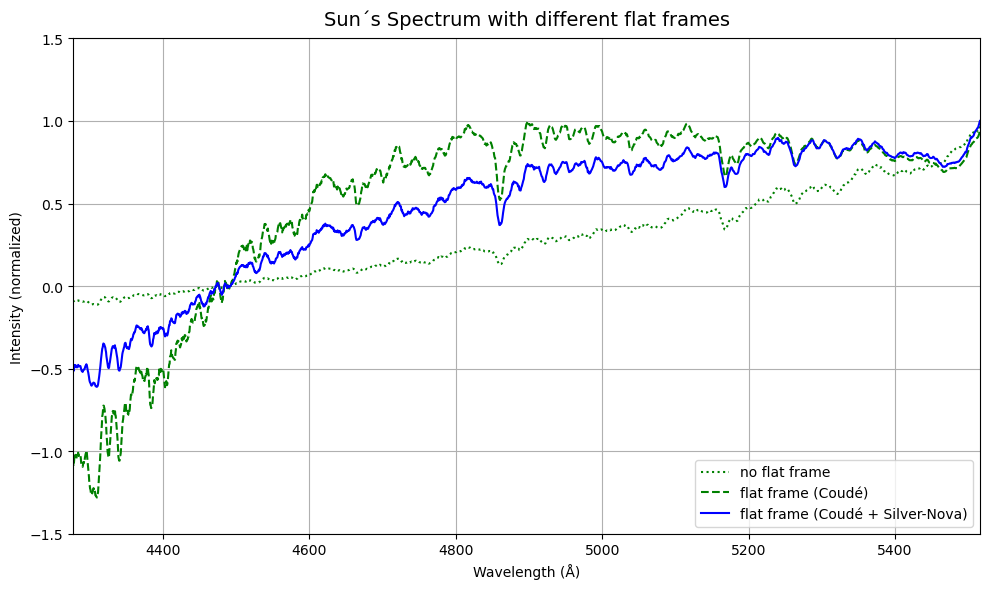

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(y_fit_3, sunSpect_without_flat_normalized, color='green', linestyle='dotted', label='no flat frame')
ax.plot(y_fit_3, sunSpect_normalized, color='green', linestyle='dashed', label='flat frame (Coudé)')
ax.plot(y_fit_3, sunSpect_corrected_normalized, color='blue', label='flat frame (Coudé + Silver-Nova)')
ax.set_xlim(min(y_fit_3), max(y_fit_3))
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel(r'Wavelength (Å)')
ax.set_ylabel('Intensity (normalized)')
ax.legend(loc='lower right')
ax.grid()
ax.set_title('Sun´s Spectrum with different flat frames', fontsize=14, pad=10)

plt.tight_layout()
plt.show()

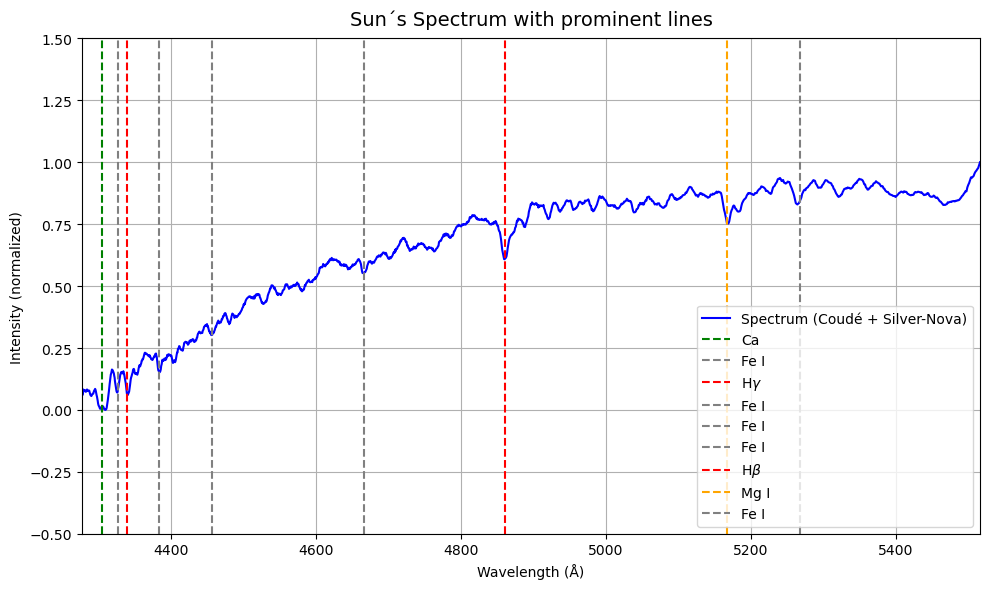

In [20]:
# Shift and normalize Sun´s corrected spectrum
sunSpect_corrected_normalized_shifted = sunSpect_corrected_normalized - min(sunSpect_corrected_normalized)
sunSpect_corrected_shifted_normalized = sunSpect_corrected_normalized_shifted / max(sunSpect_corrected_normalized_shifted)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(y_fit_3,sunSpect_corrected_shifted_normalized, color='blue', label='Spectrum (Coudé + Silver-Nova)')
ax.vlines(x=4305, ymin=-0.5, ymax=1.5, color='green', linestyle='--', label='Ca')
ax.vlines(x=4327, ymin=-0.5, ymax=1.5, color='gray', linestyle='--', label='Fe I')
ax.vlines(x=4340, ymin=-0.5, ymax=1.5, color='red', linestyle='--', label=r'H$\gamma$')
ax.vlines(x=4384, ymin=-0.5, ymax=1.5, color='gray', linestyle='--', label='Fe I')
ax.vlines(x=4457, ymin=-0.5, ymax=1.5, color='gray', linestyle='--', label='Fe I')
ax.vlines(x=4667, ymin=-0.5, ymax=1.5, color='gray', linestyle='--', label='Fe I')
ax.vlines(x=4861, ymin=-0.5, ymax=1.5, color='red', linestyle='--', label=r'H$\beta$')
ax.vlines(x=5167, ymin=-0.5, ymax=1.5, color='orange', linestyle='--', label='Mg I')
ax.vlines(x=5268, ymin=-0.5, ymax=1.5, color='gray', linestyle='--', label='Fe I')
ax.set_xlim(min(y_fit_3), max(y_fit_3))
#ax.set_xlim(4400, 4800)
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel(r'Wavelength (Å)')
ax.set_ylabel('Intensity (normalized)')
ax.legend(loc='lower right')
ax.grid()
ax.set_title('Sun´s Spectrum with prominent lines', fontsize=14, pad=10)

plt.tight_layout()
plt.show()

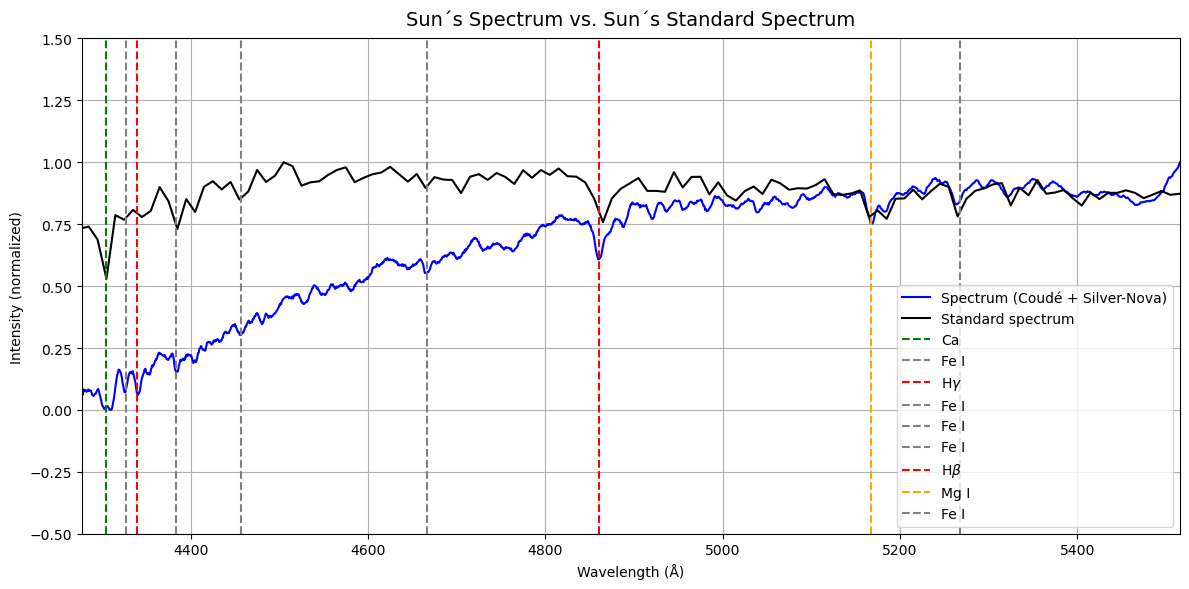

In [21]:
# Fetch standard spectrum from csv-file
standard_spectrum = pd.read_csv("standard_extraterrestrial_spectrum.csv", comment='#', header=None, names=['wavelength', 'flux'])

wavelength_standard_spectrum = standard_spectrum['wavelength'].to_numpy()
flux_standard_spectrum = standard_spectrum['flux'].to_numpy()

wavelength_standard_spectrum *= 1e4
flux_standard_spectrum = flux_standard_spectrum / max(flux_standard_spectrum)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(y_fit_3, sunSpect_corrected_shifted_normalized, color='blue', label='Spectrum (Coudé + Silver-Nova)')
ax.plot(wavelength_standard_spectrum, flux_standard_spectrum, color='black', label='Standard spectrum')
ax.vlines(x=4305, ymin=-0.5, ymax=1.5, color='green', linestyle='--', label='Ca')
ax.vlines(x=4327, ymin=-0.5, ymax=1.5, color='gray', linestyle='--', label='Fe I')
ax.vlines(x=4340, ymin=-0.5, ymax=1.5, color='red', linestyle='--', label=r'H$\gamma$')
ax.vlines(x=4384, ymin=-0.5, ymax=1.5, color='gray', linestyle='--', label='Fe I')
ax.vlines(x=4457, ymin=-0.5, ymax=1.5, color='gray', linestyle='--', label='Fe I')
ax.vlines(x=4667, ymin=-0.5, ymax=1.5, color='gray', linestyle='--', label='Fe I')
ax.vlines(x=4861, ymin=-0.5, ymax=1.5, color='red', linestyle='--', label=r'H$\beta$')
ax.vlines(x=5167, ymin=-0.5, ymax=1.5, color='orange', linestyle='--', label='Mg I')
ax.vlines(x=5268, ymin=-0.5, ymax=1.5, color='gray', linestyle='--', label='Fe I')
ax.set_xlim(min(y_fit_3), max(y_fit_3))
ax.set_ylim(-0.5, 1.5)

ax.set_xlabel(r'Wavelength (Å)')
ax.set_ylabel('Intensity (normalized)')
ax.legend(loc='lower right')
ax.grid()
ax.set_title('Sun´s Spectrum vs. Sun´s Standard Spectrum', fontsize=14, pad=10)

plt.tight_layout()
plt.show()

## 8. Auswertung der Filterkurven 

t.b.d

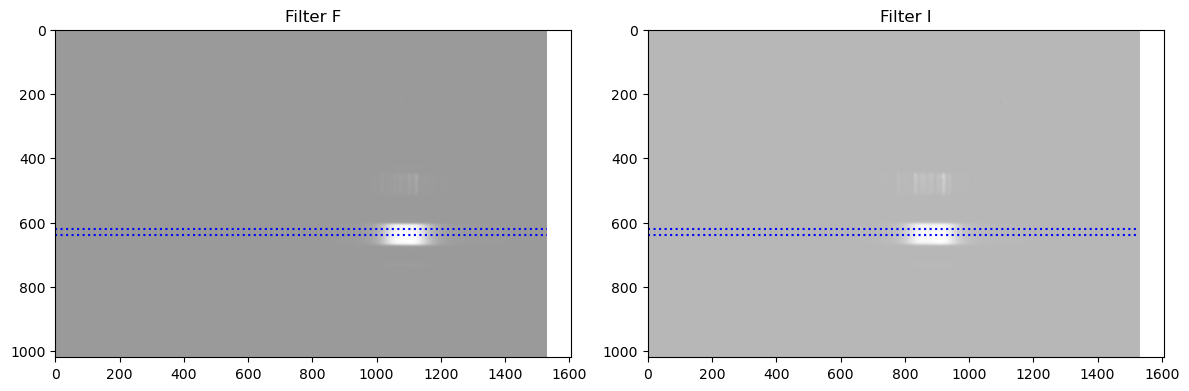

Filter F mean: 5037.009724459794
Filter F FWHM: 120.92068414770488
Filter I mean: 4852.0988810574245
Filter I FWHM: 117.1399332089829

Filter F effective wavelength: 5041.863185682317
Filter F FWHM: 125.06557151889228
Filter F effective wavelength: 4863.115204478088
Filter I FWHM: 120.65892900716426



In [22]:
# Plot Filter science frames
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(Filter_F_frame, cmap='grey')
ax[0].set_title('Filter F')
ax[0].hlines(y=620, xmin=0, xmax=1530, color='blue', linestyle='dotted')
ax[0].hlines(y=640, xmin=0, xmax=1530, color='blue', linestyle='dotted')

ax[1].imshow(Filter_I_frame, cmap='grey')
ax[1].set_title('Filter I')
ax[1].hlines(y=620, xmin=0, xmax=1530, color='blue', linestyle='dotted')
ax[1].hlines(y=640, xmin=0, xmax=1530, color='blue', linestyle='dotted')
plt.tight_layout()
plt.show()

# Shift and Normalization of filter curves
Spectfilter_F_shifted = Spectfilter_F - min(Spectfilter_F)
Spectfilter_I_shifted = Spectfilter_I - min(Spectfilter_I)

Spectfilter_F_shifted_max = max(Spectfilter_F_shifted)
Spectfilter_I_shifted_max = max(Spectfilter_I_shifted)

Spectfilter_normalization_factor = max(Spectfilter_F_shifted_max, Spectfilter_I_shifted_max)

Spectfilter_F_normalized = Spectfilter_F_shifted / Spectfilter_normalization_factor
Spectfilter_I_normalized = Spectfilter_I_shifted / Spectfilter_normalization_factor

# Fit Gaussian to filter curves
gaussian_function = models.Gaussian1D(amplitude=1, mean=4900, stddev=3)
fit_gaussian = fitting.TRFLSQFitter()


gaussian_filter_F = fit_gaussian(gaussian_function, y_fit_3, Spectfilter_F_normalized)
gaussian_filter_I = fit_gaussian(gaussian_function, y_fit_3, Spectfilter_I_normalized)

print(f'Filter F mean: {gaussian_filter_F.mean.value}')
print(f'Filter F FWHM: {gaussian_filter_F.fwhm}')
print(f'Filter I mean: {gaussian_filter_I.mean.value}')
print(f'Filter I FWHM: {gaussian_filter_I.fwhm}')
print()

# Alternative calculation of effective wavelength and FWHM

def effective_wavelength(wavelengths, transmission):

    weighted_integral = simpson(y=wavelengths * transmission, x=wavelengths)
    total_integral = simpson(y=transmission, x=wavelengths)
    return weighted_integral / total_integral

def calculate_fwhm(wavelengths, transmission):
    T_max = np.max(transmission)
    half_max = T_max / 2
    
    indices_half_max = np.where(transmission >= half_max)[0]  # Indizes, bei denen T >= T_max / 2
    lambda_left = wavelengths[indices_half_max[0]]
    lambda_right = wavelengths[indices_half_max[-1]]
    
    fwhm = lambda_right - lambda_left
    return fwhm, lambda_left, lambda_right

# Calculate effective wavelength and FWHM
Filter_F_lambda_eff = effective_wavelength(y_fit_3, Spectfilter_F_normalized)
Filter_I_lambda_eff = effective_wavelength(y_fit_3, Spectfilter_I_normalized)

Filter_F_FWHM, Filter_F_FWHM_wavelength_min, Filter_F_FWHM_wavelength_max = calculate_fwhm(y_fit_3,  Spectfilter_F_normalized)
Filter_I_FWHM, Filter_I_FWHM_wavelength_min, Filter_I_FWHM_wavelength_max = calculate_fwhm(y_fit_3,  Spectfilter_I_normalized)

print(f'Filter F effective wavelength: {Filter_F_lambda_eff}')
print(f'Filter F FWHM: {Filter_F_FWHM}')
print(f'Filter F effective wavelength: {Filter_I_lambda_eff}')
print(f'Filter I FWHM: {Filter_I_FWHM}')
print()

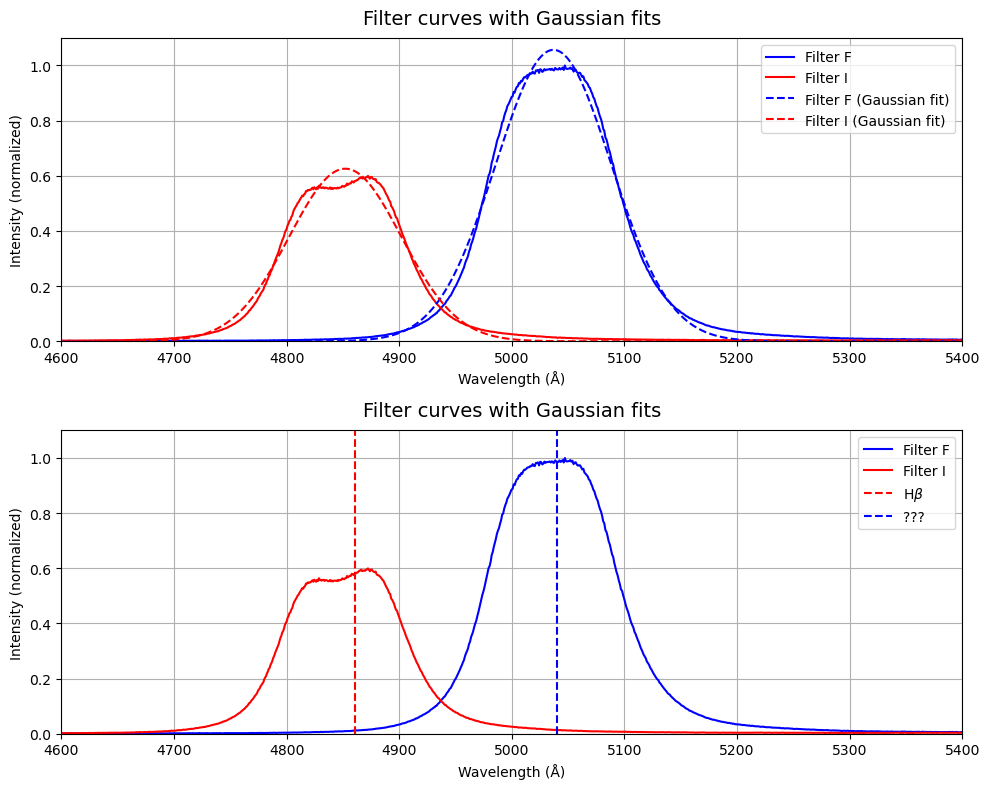

In [23]:
# Plot of filter curves with Gaussian fit and effective wavelength/FWHM 
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(y_fit_3, Spectfilter_F_normalized, color='blue', label='Filter F')
ax[0].plot(y_fit_3, Spectfilter_I_normalized, color='red', label='Filter I')
ax[0].plot(y_fit_3, gaussian_filter_F(y_fit_3), color='blue', linestyle='dashed', label='Filter F (Gaussian fit)')
ax[0].plot(y_fit_3, gaussian_filter_I(y_fit_3), color='red', linestyle='dashed', label='Filter I (Gaussian fit)')
ax[0].set_xlim(4600, 5400)
ax[0].set_ylim(0, 1.1)
ax[0].set_xlabel(r'Wavelength (Å)')
ax[0].set_ylabel('Intensity (normalized)')
ax[0].set_title('Filter curves with Gaussian fits', fontsize=14, pad=10)
ax[0].legend()
ax[0].grid()

ax[1].plot(y_fit_3, Spectfilter_F_normalized, color='blue', label='Filter F')
ax[1].plot(y_fit_3, Spectfilter_I_normalized, color='red', label='Filter I')
ax[1].vlines(x=4861, ymin=0, ymax=1.1, color='red', linestyle='dashed', label=r'H$\beta$')
#ax[1].hlines(y=max(Spectfilter_I_normalized)/2, xmin=Filter_I_FWHM_wavelength_min, xmax=Filter_I_FWHM_wavelength_max, color='red', linestyle='dotted', label='Filter I (FWHM)')
ax[1].vlines(x=5040, ymin=0, ymax=1.1, color='blue', linestyle='dashed', label=r'???')
#ax[1].hlines(y=max(Spectfilter_F_normalized)/2, xmin=Filter_F_FWHM_wavelength_min, xmax=Filter_F_FWHM_wavelength_max, color='blue', linestyle='dotted', label='Filter F (FWHM)')
ax[1].set_xlim(4600, 5400)
ax[1].set_ylim(0, 1.1)
ax[1].set_xlabel(r'Wavelength (Å)')
ax[1].set_ylabel('Intensity (normalized)')
ax[1].set_title('Filter curves with Gaussian fits', fontsize=14, pad=10)
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()